In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from decorator import append
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from BayesianLLNN import BaseNetwork
from BayesianLLNN import BayesianLastLayer,PredLastLayer,TrainLastLayer
from baseNN import GetNeuralNetwork, PredNormal, TrainNN
from sklearn.metrics import mean_squared_error

In [3]:
def set_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


In [4]:
def sample_strict_ood(n, loc=-6, scale=1, min_val=-np.inf, max_val=-4):
    samples = []
    while len(samples) < n:
        s = np.random.normal(loc, scale, size=(n, 1))
        s = s[s < max_val]
        samples.extend(s.tolist())
    return np.array(samples[:n]).astype(np.float32).reshape(-1, 1)

In [5]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
#simulate data ID bereich [-4,4]
X_train = np.random.uniform(-4,4,800).reshape(-1,1).astype(np.float32)
#by adding the gaussian noise we are introducing aleatoric uncertainty
y_train = (np.sin(X_train) +np.random.normal(scale=0.4,size=X_train.shape)).astype(np.float32)

# We sample from a normal gaussian for the OOD data.
#WE ARE introducing OOD TO TESTSET
X_id = np.random.uniform(-4, 4, size=(100, 1)).reshape(-1,1)   .astype(np.float32)      # ID
X_ood_left = sample_strict_ood(50)
X_ood_right = sample_strict_ood(50,6,1,min_val=4,max_val=np.inf)# right OOD
X_test = np.vstack([X_ood_left, X_id, X_ood_right])
#X_test = np.linspace(-8, 8, 200).reshape(-1, 1).astype(np.float32)

y_test = (np.sin(X_test) + np.random.normal(scale=0.4,size=X_test.shape)).astype(np.float32)

tenX = torch.from_numpy(X_train).to(device)
tenY = torch.from_numpy(y_train).to(device)
tenXTest = torch.from_numpy(X_test).to(device)
tenYTest = torch.from_numpy(y_test).to(device)
tenDF = TensorDataset(tenX,tenY)
trainLoader = DataLoader(tenDF,batch_size=32,shuffle=True)
InDist = [False]*50
InDist.extend([True]*100)
InDist.extend([False]*50)

In [6]:
mapNN = GetNeuralNetwork()
TrainNN(mapNN, trainLoader, epochs=100)
mean_map, std_map = PredNormal(mapNN, tenXTest)

Epoch: 0 | Loss: 0.40914
Epoch: 20 | Loss: 0.15372
Epoch: 40 | Loss: 0.16309
Epoch: 60 | Loss: 0.15470
Epoch: 80 | Loss: 0.15372


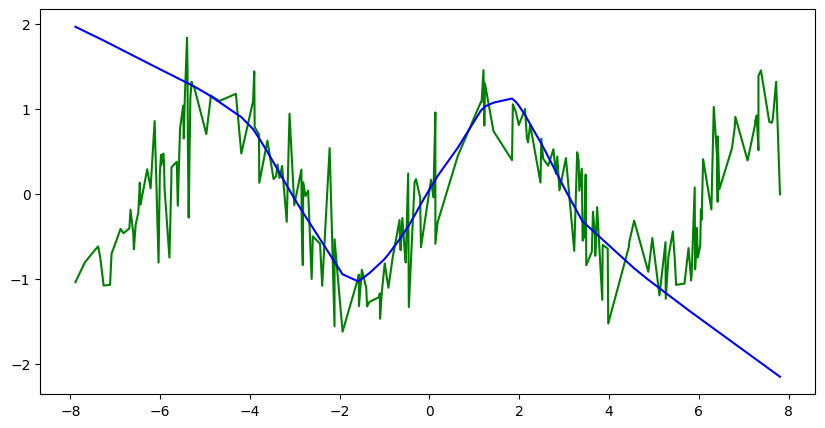

In [7]:
# Sortiere alles nach X_test für saubere Plotlinien
sort_idx = np.argsort(X_test.flatten())

X_test_sorted = X_test[sort_idx]
y_test_sorted = y_test[sort_idx]
mean_map_sorted = mean_map[sort_idx]

plt.figure(figsize=(10,5))
plt.plot(X_test_sorted, y_test_sorted, 'g-', label='True')
plt.plot(X_test_sorted, mean_map_sorted, "b-", label='MAP NN Mean')
plt.show()

In [8]:
# Base + bayesian Last Layer model
base = BaseNetwork(1).to(device)
head = nn.Linear(16,1).to(device)
baseMod = nn.Sequential(base,head)
TrainNN(baseMod,trainLoader,100)
# freezing base weights
for p in baseMod.parameters():
    p.requires_grad = False
lastLayer = BayesianLastLayer(in_features=16,out_features=1, logvals=-0.5,prior_sigma=0.5).to(device)
TrainLastLayer(base,lastLayer,trainLoader,epochs=100)
meanB, stdB = PredLastLayer(base,lastLayer,tenXTest,nSamples=110)

Epoch: 0 | Loss: 0.37285
Epoch: 20 | Loss: 0.19595
Epoch: 40 | Loss: 0.21594
Epoch: 60 | Loss: 0.19982
Epoch: 80 | Loss: 0.19402


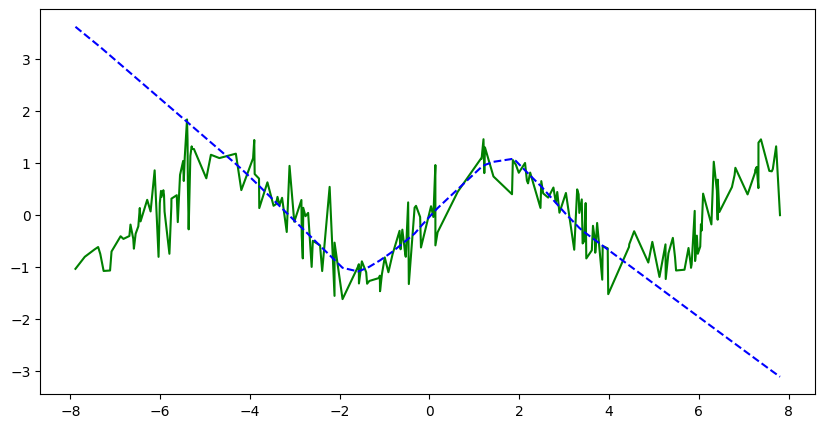

In [9]:
meanB_sorted = meanB[sort_idx]
stdB_sorted = stdB[sort_idx]
plt.figure(figsize=(10,5))
# epistemic uncertainty
plt.plot(X_test_sorted, y_test_sorted, 'g-', label='True')
plt.plot(X_test_sorted, meanB_sorted, 'b--', label='MAP NN Mean')
plt.show()


In [10]:
#
InDist = np.array(InDist)
InDist_sorted = InDist[sort_idx]
OODist = [not x for x in InDist_sorted]

mapUnID = std_map[InDist]
mapUnOOD = std_map[OODist]

bllUnID = stdB[InDist]
bllUnOOD = stdB[OODist]

print(f"MAP NN: In-dist uncertainty = {mapUnID.mean():.4f}, OOD uncertainty = {mapUnOOD.mean():.4f}")
print(f"Bayesian Last Layer: In-dist uncertainty = {bllUnID.mean():.4f}, OOD average std = {bllUnOOD.mean():.4f}")


MAP NN: In-dist uncertainty = 0.0000, OOD uncertainty = 0.0000
Bayesian Last Layer: In-dist uncertainty = 0.7751, OOD average std = 1.8725


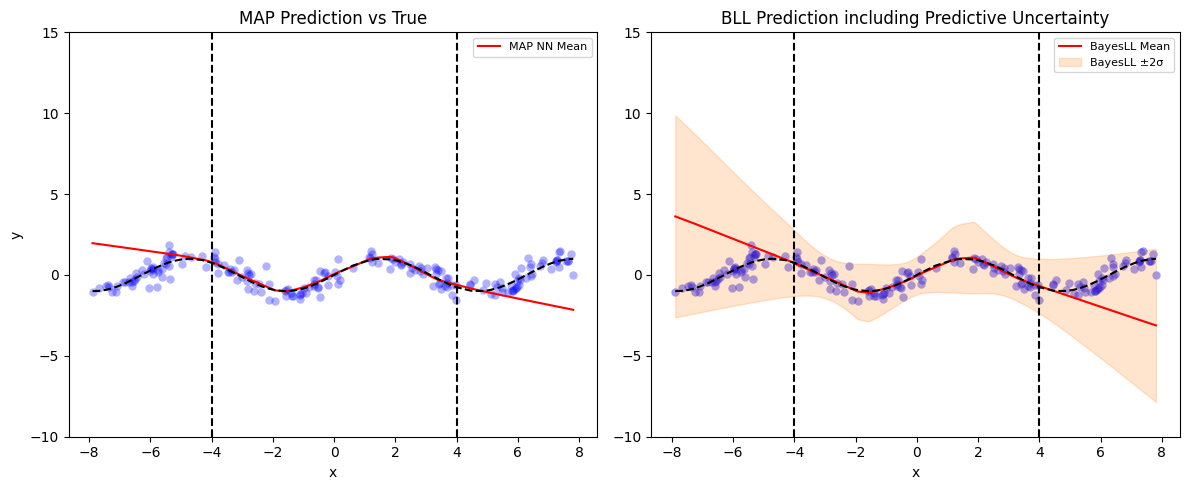

<Figure size 640x480 with 0 Axes>

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Plot 1: MAP
ax1.scatter( X_test_sorted, y_test_sorted, alpha=0.3, linewidths=0.01, color="b" )
ax1.plot(    X_test_sorted, mean_map_sorted, 'r-', label='MAP NN Mean' )
ax1.plot(X_test_sorted,np.sin(X_test_sorted), 'k--', )
ax1.axvline(-4, color='k', ls='--')
ax1.axvline( 4, color='k', ls='--')
ax1.legend(loc="upper right", fontsize=8)
ax1.set_title('MAP Prediction vs True')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_yticks(np.arange(-10, 20, 5))
# Plot 2: BayesLL
ax2.scatter( X_test_sorted, y_test_sorted, alpha=0.4, linewidths=0.01, color="b" )
ax2.plot(    X_test_sorted, meanB_sorted, 'r-', label='BayesLL Mean' )
ax2.plot(X_test_sorted,np.sin(X_test_sorted), 'k--', )
ax2.fill_between(X_test_sorted.flatten(),
                 meanB_sorted-2*stdB_sorted,
                 meanB_sorted+2*stdB_sorted,
                 alpha=0.2, label='BayesLL ±2σ', color ='tab:orange' )
ax2.axvline(-4, color='k', ls='--')
ax2.axvline( 4, color='k', ls='--')
ax2.legend(loc="upper right", fontsize=8)
ax2.set_title('BLL Prediction including Predictive Uncertainty')
ax2.set_xlabel('x')
ax2.set_yticks(np.arange(-10, 20, 5))
plt.tight_layout()
plt.show()
plt.savefig("../results/Simulation.png")


Table for ID vs OOD MSE

In [12]:
mse_id_map = mean_squared_error(y_test_sorted[InDist_sorted],mean_map_sorted[InDist_sorted])
mse_ood_map = mean_squared_error(y_test_sorted[OODist],mean_map_sorted[OODist])

bll_id_mse =  mean_squared_error(y_test_sorted[InDist_sorted],meanB_sorted[InDist_sorted])
bll_ood_mse =  mean_squared_error(y_test_sorted[OODist],meanB_sorted[OODist])
print("MSE, MAP vs BNN:\n")
print(f"Map ID:{mse_id_map}")
print(f"Map OOD:{mse_ood_map}")
print(f"BLL ID:{bll_id_mse}")
print(f"BLL OOD:{bll_ood_mse}")


MSE, MAP vs BNN:

Map ID:0.16594381630420685
Map OOD:2.9525327682495117
BLL ID:0.16262178122997284
BLL OOD:5.917141914367676
